In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import re
import pickle
import unicodedata
import string
import re
import random
import pandas as pd
import numpy as np
from gensim.models.keyedvectors import KeyedVectors
import operator
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print(device)

cuda:0


In [3]:
skip_training = True

In [4]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(str, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [5]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [7]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    
    # Split every line into pairs and normalize
    pairs = [[s for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
def filterPair(p):    
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [10]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Counting words...")
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('fin', 'mk', False)

Reading lines...
Read 2392808 sentence pairs
Counting words...
Trimmed to 1915404 sentence pairs
Counted words:
fin 531025
mk 340779


In [11]:
pairs_train, pairs_test = train_test_split(pairs, test_size=0.05, random_state=42)

In [12]:
from torch.nn.utils.rnn import pad_sequence

def collate(list_of_samples):
    # sort a list by sequence length
    list_of_samples.sort(key=lambda x: len(x[0]), reverse=True)

    input_seqs, output_seqs = zip(*list_of_samples)
    input_seq_lengths = [len(seq) for seq in input_seqs]
    output_seq_lengths = [len(seq) for seq in output_seqs]

    padding_value = 0
    
    pad_input_seqs = pad_sequence(input_seqs, batch_first=False, padding_value=padding_value)
    pad_output_seqs = []
    for i in output_seqs:
        padded = i.new_zeros(max(output_seq_lengths) - i.size(0))
        pad_output_seqs.append(torch.cat((i, padded.view(-1, 1)), dim=0))
    
    pad_output_seqs = torch.stack(pad_output_seqs)
    pad_output_seqs = pad_output_seqs.permute(1, 0, 2)

    return pad_input_seqs, input_seq_lengths, pad_output_seqs, output_seq_lengths

In [13]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):
    def __init__(self, dictionary_size, hidden_size, dropout_p=0.2, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(dictionary_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, 
                          hidden_size, 
                          num_layers=self.num_layers,
                          bidirectional=True
                         )

    def forward(self, pad_seqs, seq_lengths, hidden):
        embedded = self.embedding(pad_seqs).squeeze(dim=2)
        packed = pack_padded_sequence(embedded, seq_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs = pad_packed_sequence(outputs)[0]
        return outputs, hidden

    def init_hidden(self, batch_size=1, device=device):
        return (torch.zeros(2*self.num_layers, batch_size, self.hidden_size, device=device), torch.zeros(2*self.num_layers, batch_size, self.hidden_size, device=device))

In [14]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_dictionary_size, dropout_p=0.2, num_layers=1):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(output_dictionary_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, 
                          hidden_size, 
                          num_layers=self.num_layers,
                          bidirectional=False
                         )
        self.lin = nn.Linear(hidden_size, output_dictionary_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, hidden, pad_target_seqs=None, teacher_forcing=False):
        batch_size = hidden[1].size(1)
        prev_word = torch.tensor(SOS_token * np.ones((1, batch_size)), device=device, dtype=torch.int64)
        max_length = pad_target_seqs.size(0) if pad_target_seqs is not None else MAX_LENGTH
        outputs = []
        for t in range(max_length):
            prev_word = prev_word.view(1, -1)
            output = self.embedding(prev_word)
            output, hidden = self.lstm(output, hidden)
            output = self.softmax(self.lin(output))
    
            outputs.append(output)

            if teacher_forcing:
                prev_word = pad_target_seqs[t]
            else:
                topv, topi = output[0, :].topk(1)
                prev_word = topi.squeeze().detach()

        outputs = torch.cat(outputs, dim=0)
        return outputs, hidden

In [15]:
restore_checkpoint = False

In [16]:
if restore_checkpoint == True:
    encoder_checkpoint = torch.load('model/encoder_opt', map_location="cuda:0")
    decoder_checkpoint = torch.load('model/decoder_opt', map_location="cuda:0")

In [17]:
hidden_size = 256
encoder = Encoder(input_lang.n_words, hidden_size, dropout_p=0.2).to(device)
decoder = Decoder(hidden_size, output_lang.n_words, dropout_p=0.2).to(device)

if restore_checkpoint == True:
    encoder.load_state_dict(encoder_checkpoint['model_state_dict'], )
    decoder.load_state_dict(decoder_checkpoint['model_state_dict'])

    encoder.cuda()
    decoder.cuda()
    encoder.train()
    decoder.train()

In [18]:
criterion = nn.NLLLoss(reduction='none')

def compute_loss(decoder_outputs, pad_target_seqs, padding_value=0):  
    n = 0
    loss = 0
    for i in range(decoder_outputs.shape[1]):
        p_arr = []
        t_arr = []
        p = decoder_outputs[:, i, :]
        t = pad_target_seqs[:, i].squeeze()
        for word in range(len(t)):
            if t[word] != padding_value:
                p_arr.append(p[word])
                t_arr.append(t[word])
                n += 1
        p_arr = torch.stack(p_arr)
        t_arr = torch.stack(t_arr)
        loss += criterion(p_arr, t_arr).sum()
    loss = loss / n

    return loss

In [19]:
n_epochs = 30
teacher_forcing_ratio = 0.5

encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.01)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.01)

In [20]:
if restore_checkpoint == True:
    encoder_optimizer.load_state_dict(encoder_checkpoint['optimizer'])
    decoder_optimizer.load_state_dict(decoder_checkpoint['optimizer'])
    
    for state in encoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

    for state in decoder_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cuda()

In [21]:
training_pairs = [tensorsFromPair(random.choice(pairs_train)) for i in range(20000)]        
pairs_batch_train = DataLoader(dataset=training_pairs,
                 batch_size=64,
                 shuffle=True,
                 collate_fn=collate,
                 pin_memory=True)

In [22]:
if skip_training == False:
    for epoch in range(n_epochs):
        testing_pairs = [tensorsFromPair(random.choice(pairs_test)) for i in range(1000)]
        pairs_batch_test = DataLoader(dataset=testing_pairs,
                 batch_size=64,
                 shuffle=True,
                 collate_fn=collate,
                 pin_memory=True)

        complete_loss = 0
        for i, batch in enumerate(pairs_batch_train):
            pad_input_seqs, input_seq_lengths, pad_target_seqs, target_seq_lengths = batch
            batch_size = pad_input_seqs.size(1)
            pad_input_seqs, pad_target_seqs = pad_input_seqs.to(device), pad_target_seqs.to(device)

            encoder_hidden = encoder.init_hidden(batch_size, device)
            
            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            # Encode input sequence
            _, encoder_hidden = encoder(pad_input_seqs, input_seq_lengths, encoder_hidden)
            # Decode using target sequence for teacher forcing
            decoder_hidden = (encoder_hidden[0].mean(0, keepdim=True),encoder_hidden[1].mean(0, keepdim=True))

            if random.random() < teacher_forcing_ratio:
                teacher_forcing = True
            else:
                teacher_forcing = False
                
            decoder_outputs, decoder_hidden = decoder(decoder_hidden, pad_target_seqs, teacher_forcing=teacher_forcing)
            loss = compute_loss(decoder_outputs, pad_target_seqs, padding_value=0)
            loss.backward()
            
            complete_loss += loss

            encoder_optimizer.step()
            decoder_optimizer.step()
            
        print('[Epoch: %d] loss: %.4f' % (epoch + 1, complete_loss / len(pairs_batch_train)))
        with open("loss/loss.txt", "a") as f:
            f.write(str(complete_loss.item() / len(pairs_batch_train)) + '\n')  
            
        test_loss = 0
        with torch.no_grad():
            for i, batch in enumerate(pairs_batch_test):
                pad_input_seqs, input_seq_lengths, pad_target_seqs, target_seq_lengths = batch
                batch_size = pad_input_seqs.size(1)
                pad_input_seqs, pad_target_seqs = pad_input_seqs.to(device), pad_target_seqs.to(device)

                encoder_hidden = encoder.init_hidden(batch_size, device)

                # Encode input sequence
                _, encoder_hidden = encoder(pad_input_seqs, input_seq_lengths, encoder_hidden)
                # Decode using target sequence for teacher forcing
                decoder_hidden = (encoder_hidden[0].mean(0, keepdim=True),encoder_hidden[1].mean(0, keepdim=True))

                decoder_outputs, decoder_hidden = decoder(decoder_hidden, pad_target_seqs, teacher_forcing=False)
                loss = compute_loss(decoder_outputs, pad_target_seqs, padding_value=0)
                test_loss += loss

            print('[Epoch: %d] test loss: %.4f' % (epoch + 1, test_loss / len(pairs_batch_test)))
            with open("loss/test_loss.txt", "a") as f:
                f.write(str(test_loss.item() / len(pairs_batch_test)) + '\n')
        
        
        if (epoch + 1) % 5 == 0:     
            state = {'epoch': epoch + 1, 'state_dict': encoder.state_dict(),
                 'optimizer': encoder_optimizer.state_dict(), 'model_state_dict': encoder.state_dict()}
            torch.save(state, 'model/encoder_opt')

            state = {'epoch': epoch + 1, 'state_dict': decoder.state_dict(),
                 'optimizer': decoder_optimizer.state_dict(), 'model_state_dict': decoder.state_dict()}
            torch.save(state, 'model/decoder_opt')

            torch.save(encoder, 'model/encoder')
            torch.save(decoder, 'mode/decoder')
    
    print('Finished Training')

In [23]:
if skip_training == False:
    torch.save(encoder, 'model/encoder')
    torch.save(decoder, 'model/decoder')
else:
    encoder = torch.load('model_test/encoder')
    encoder.eval()
    
    decoder = torch.load('model_test/decoder')
    decoder.eval()

/u/15/porjazd1/unix/.local/lib/python3.6/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/u/15/porjazd1/unix/.local/lib/python3.6/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


In [24]:
# Plotting the learned embeddings
keys_fin = ['mies', 'nainen', 'englanti', 'vuotta', 'kaunis', 'vuori', 'puhua', 'missä', 'peikko']
keys_mk = ['маж','жена', 'англија', 'година', 'убава', 'планина', 'зборува', 'каде', 'трол']

fin_words_idx = [input_lang.word2index[i] for i in keys_fin]
mk_words_idx = [output_lang.word2index[i] for i in keys_mk]

In [25]:
def get_similar_words(model, words_idx, n):
    similar_words = []
    t = model.embedding

    for word in words_idx:
        # normalize rows
        normalized_embedding = t.weight/((t.weight**2).sum(0)**0.5).expand_as(t.weight)

        v = model.embedding(torch.LongTensor([word])[0].to(device))
        v = v / ((v**2).sum()**0.5).expand_as(v)

        similarity, words = torch.topk(torch.mv(normalized_embedding,v), n)
        similar_words.append(words)
    return similar_words

In [26]:
similar_words_fin = get_similar_words(encoder, fin_words_idx, 20)
similar_words_mk = get_similar_words(decoder, mk_words_idx, 20)

In [40]:
def get_words_from_idx(similar_words, lang):
    words = []
    temp = []
    for sent in similar_words:
        for word in sent:
            temp.append(lang.index2word[word.item()])
        words.append(temp)
        temp = []
    return words

In [41]:
fin_words = get_words_from_idx(similar_words_fin, input_lang)
mk_words = get_words_from_idx(similar_words_mk, output_lang)

In [44]:
def embeddings_from_words(words, lang, model):
    embeddings = []
    temp = []
    for sent in words:
        for word in sent:
            index = lang.word2index[word]
            te = model.embedding(torch.LongTensor([index])[0].to(device)).data
            temp.append(te.to('cpu').numpy())
        embeddings.append(temp)
        temp = []
    return embeddings

In [46]:
fin_embeddings = embeddings_from_words(fin_words, input_lang, encoder)
mk_embeddings = embeddings_from_words(mk_words, output_lang, decoder)

In [47]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

embedding_clusters_fin = np.array(fin_embeddings)
embedding_clusters_mk = np.array(mk_embeddings)

n, m, k = embedding_clusters_fin.shape
n, m, k = embedding_clusters_mk.shape

tsne_model_fin_2d = TSNE(perplexity=20, n_components=2, init='pca', n_iter=2000, random_state=32)
tsne_model_mk_2d = TSNE(perplexity=20, n_components=2, init='pca', n_iter=2000, random_state=32)

embeddings_fin_2d = np.array(tsne_model_fin_2d.fit_transform(embedding_clusters_fin.reshape(n * m, k))).reshape(n, m, 2)
embeddings_mk_2d = np.array(tsne_model_mk_2d.fit_transform(embedding_clusters_mk.reshape(n * m, k))).reshape(n, m, 2)


In [48]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, alpha, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color], alpha=alpha, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='eps')
    plt.show()

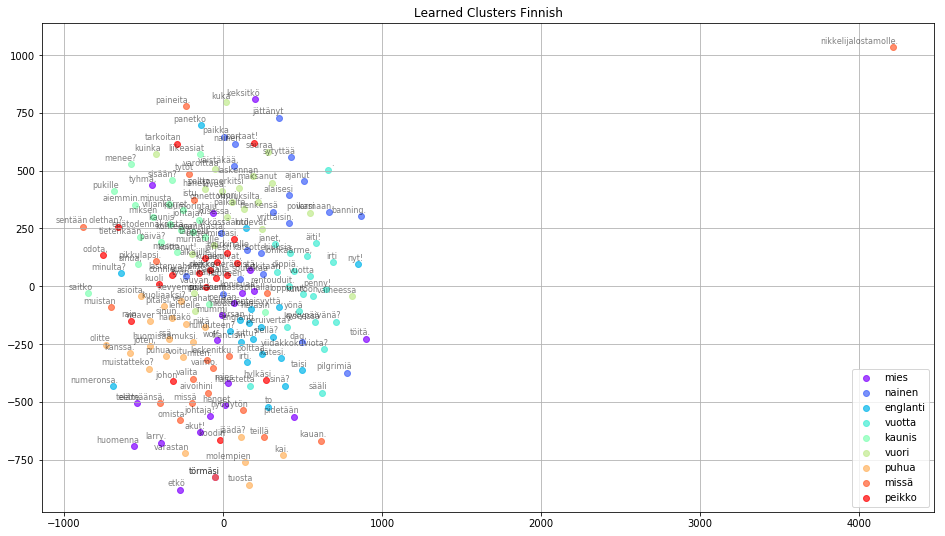

In [49]:
tsne_plot_similar_words('Learned Clusters Finnish', keys_fin, embeddings_fin_2d, fin_words, 0.7,
                        'fin_clusters.eps')

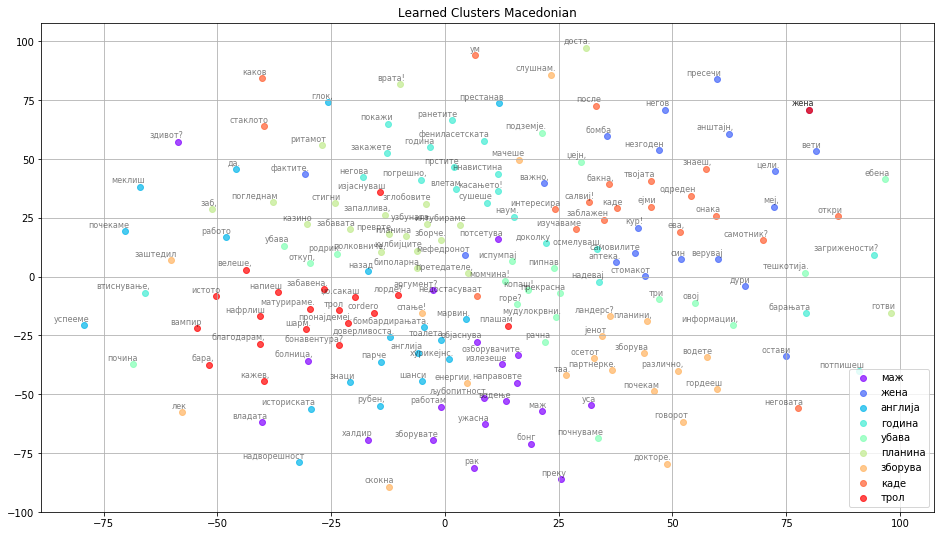

In [50]:
tsne_plot_similar_words('Learned Clusters Macedonian', keys_mk, embeddings_mk_2d, mk_words, 0.7,
                        'mk_clusters.eps')

In [51]:
def evaluate(input_seq):
    with torch.no_grad():
        input_length = input_seq.size(0)
        batch_size = 1

        encoder_hidden = encoder.init_hidden(batch_size, device)
        input_seq = input_seq.view(-1, 1, 1).to(device)
        encoder_output, encoder_hidden = encoder(input_seq, [input_length], encoder_hidden)

        decoder_hidden = (encoder_hidden[0].mean(0, keepdim=True),encoder_hidden[1].mean(0, keepdim=True))
        decoder_outputs, decoder_hidden = decoder(decoder_hidden, pad_target_seqs=None, teacher_forcing=False)

        output_seq = []
        for t in range(decoder_outputs.size(0)):
            topv, topi = decoder_outputs[t].data.topk(1)
            output_seq.append(topi.item())
            if topi.item() == EOS_token:
                break

    return output_seq

In [52]:
# Evaluate random sentences from the training set
print('\nEvaluate on training data:')
print('-----------------------------')
for i in range(10):
    input_sentence, target_sentence = training_pairs[np.random.choice(len(training_pairs))]
    print('>', ' '.join(input_lang.index2word[i.item()] for i in input_sentence))
    print('=', ' '.join(output_lang.index2word[i.item()] for i in target_sentence))
    output_sentence = evaluate(input_sentence)
    print('<', ' '.join(output_lang.index2word[i] for i in output_sentence))
    print('')


Evaluate on training data:
-----------------------------
> kerää tavarasi, me häivymme. EOS
= земи си ги работите. EOS
< брус, го имате   EOS

> tässä on varmasti ainakin tonni. EOS
= мора да има барем илјада долари тука. EOS
< ова е е да EOS

> nähdäkseni prometheus. EOS
= најдобра претпоставка? прометеј. EOS
< го EOS

> joku oli pyyhkinyt sen pois. EOS
= некој ја избришал. EOS
< види го го го убијам капетане. EOS

> se on bonnie . hän EOS
= не, туку бони. EOS
< организација за лобирање? EOS

> ammuttu! EOS
= продупчено! EOS
< седи! EOS

> tiesit sen. EOS
= морав да погледнам. EOS
< тоа отсекогаш дека ќе EOS

> hengailitko heidän kanssaan? EOS
= работевте со нив? EOS
< мртов ли го правам обиколка. EOS

> kenen idea tämä oli? EOS
= чија беше оваа идеја? EOS
< тоа е таа? EOS

> anteeksi, anteeksi, anteeksi. EOS
= пардон, пардон, пардон. EOS
< извинете што работам? EOS



In [32]:
def calculate_BLEU(pairs_test):
    testing_pairs = [tensorsFromPair(pairs_test[i]) for i in range(int(len(pairs_test)/10))]
    bleu_score = 0
    for i in range(len(testing_pairs)):
        input_sentence, target_sentence = testing_pairs[i]    
        reference = []
        candidate = []
        for word in target_sentence:
            if output_lang.index2word[word.item()] != 'EOS':
                reference.append(output_lang.index2word[word.item()])

        output_sentence = evaluate(input_sentence)
        for word in output_sentence:
            if output_lang.index2word[word] != 'EOS':
                candidate.append(output_lang.index2word[word])

#         bleu_score += sentence_bleu([reference], candidate)
        bleu_score += sentence_bleu([reference], candidate, weights=(0, 1, 0, 0))
    return bleu_score / int(len(pairs_test)/10)

In [33]:
calculate_BLEU(pairs_test)

0.01130794768405675

In [53]:
import matplotlib.pyplot as plt

def plot_loss():
    train_loss = []
    with open('loss/loss.txt', 'r') as f:
        for row in f:
            train_loss.append(float(row.rstrip('\n')))

    test_loss = []
    with open('loss/test_loss.txt', 'r') as f:
        for row in f:
            test_loss.append(float(row.rstrip('\n')))

    epochs = np.arange(1, 31, 1)

    plt.plot(epochs, train_loss)
    plt.plot(epochs, test_loss)
    plt.legend(['train', 'test'])
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('Loss comparison')
    plt.show()

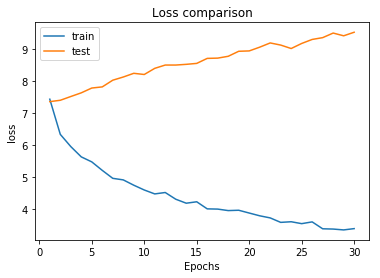

In [54]:
plot_loss()